## Initialization
### Import necessary libraries

In [1]:
!pip install --user kornia utils

In [2]:
import numpy as np
import datetime
from numpy import ndarray
from typing import List, Union, Any, Type, Tuple, NoReturn
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.pyplot import Axes, Figure
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg19
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
import os
import kornia
import utils
import json
import copy

### Define folder paths

In [3]:
# Define base folder
base_folder_path = os.getcwd()

## Load and visualise data
### Print general information about data samples

In [30]:
# Load torch file with cartpole samples
data_cartpole = torch.load(os.path.join(base_folder_path, "cartpole_swingup_40000_50000.pt"))

# Downsample and rescale observations to allow for faster training
DownSampleTo84 = nn.UpsamplingBilinear2d(size=84)
data_cartpole[0] = DownSampleTo84(torch.tensor(data_cartpole[0])/255.)
data_cartpole[1] = DownSampleTo84(torch.tensor(data_cartpole[1])/255.)

# Print observation dimensions and corresponding dimension names
print("Total number of variables: {}".format(len(data_cartpole)))
print("")
print("Observation dim sizes and corresponding names")
print(data_cartpole[0].shape)
print("(Batch dim, image dim, height, width)")
print("")
# It can be seen that image dim is of size 9.
# This is because each observation consists of three RGB images stacked upon eachother  
# 0:3 first  image
# 3:6 second image
# 6:9 third  image

# Print shapes of sample variables
tuple_values = ["obs", "next_obs", "action", "reward", "not_done"]
print("Names and shapes of sample variables:")
for i in range(5):
    print(tuple_values[i] + " size: " + str(data_cartpole[i].shape))

Total number of samples: 5

Observation dim sizes and corresponding names
torch.Size([10000, 9, 84, 84])
(Batch dim, image dim, height, width)

Names and shapes of sample variables:
obs size: torch.Size([10000, 9, 84, 84])
next_obs size: torch.Size([10000, 9, 84, 84])
action size: (10000, 1)
reward size: (10000, 1)
not_done size: (10000, 1)


### Visualisation of observations

C:\Users\bjoer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  """
C:\Users\bjoer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  """
C:\Users\bjoer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  """
C:\Users\bjoer\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be rem

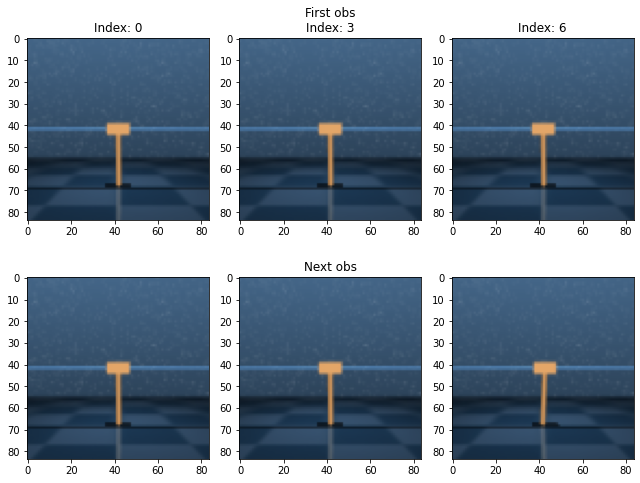

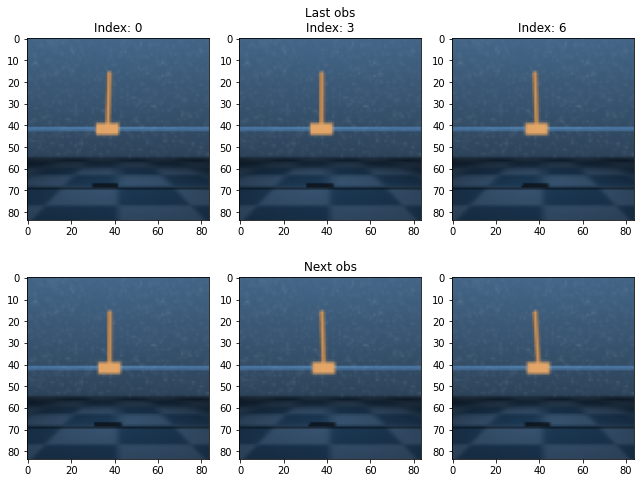

In [31]:
# Plot first observation
sample = data_cartpole[0][0].numpy()
plt.figure(1,figsize=(9, 7))
for i in [0, 3, 6]:
    plt.subplot(2, 3, i/3 + 1)
    plt.imshow(np.moveaxis(sample[i:(i+3)], 0, -1))
    if i == 3:
        plt.title("First obs\nIndex: " + str(i))
    else:
        plt.title("Index: " + str(i))
sample = data_cartpole[1][0].numpy()
for i in [0, 3, 6]:
    plt.subplot(2, 3, i/3 + 4)
    plt.imshow(np.moveaxis(sample[i:(i+3)], 0, -1))
    if i == 3:
        plt.title("Next obs")
plt.tight_layout()

# Plot last observation
sample = data_cartpole[0][-1].numpy()
plt.figure(2,figsize=(9, 7))
plt.title("Last obs")
for i in [0, 3, 6]:
    plt.subplot(2, 3, i/3 + 1)
    plt.imshow(np.moveaxis(sample[i:(i+3)], 0, -1))
    if i == 3:
        plt.title("Last obs\nIndex: " + str(i))
    else:
        plt.title("Index: " + str(i))
sample = data_cartpole[1][-1].numpy()
for i in [0, 3, 6]:
    plt.subplot(2, 3, i/3 + 4)
    plt.imshow(np.moveaxis(sample[i:(i+3)], 0, -1))
    if i == 3:
        plt.title("Next obs")
plt.tight_layout()

### Example of sample values

In [6]:
print("First obs values:")
for i in range(2,5):
    print(tuple_values[i] + ": " + str(data_cartpole[i][0]))

print("\nLast obs values:")
for i in range(2,5):
    print(tuple_values[i] + ": " + str(data_cartpole[i][-1]))

First obs values:
action: [0.99095297]
reward: [0.00045891]
not_done: [1.]

Last obs values:
action: [-0.23676331]
reward: [7.838538]
not_done: [1.]


### Extract input and target observations

In [32]:
# Based on the above we save the frames of interest. I.e. we save the last frame
# for each triplet of RGB frames and use next_obs as the target.
# input_frames and target_frames then consists of 10000 input, output pairs. 
# Each sample is then a RGB image (first dim), with height 84 (second dim),
# and width 84 (third dim)
permuted_indicies = torch.randperm(data_cartpole[0].shape[0])
input_frames = data_cartpole[0][permuted_indicies, -3:, :, :]
print(input_frames.shape)
target_frames = data_cartpole[1][permuted_indicies, -3:, :, :]
print(target_frames.shape)

torch.Size([10000, 3, 84, 84])
torch.Size([10000, 3, 84, 84])


## Replay buffer definition

In [33]:
# Slightly modified version of: https://github.com/denisyarats/drq/blob/5ad46da6bc185492742f5fbddec4efb829ee1a07/replay_buffer.py#L16
class ReplayBuffer(object):
    """Buffer to store environment transitions."""
    def __init__(self,
                 obs_shape: tuple,
                 capacity: int,
                 image_pad: int = 4,
                 device: str = "cuda"):
        self.capacity = capacity
        self.device = device

        self.aug_trans = nn.Sequential(
            nn.ReplicationPad2d(image_pad),
            kornia.augmentation.RandomCrop((obs_shape[-1], obs_shape[-1])))

        self.obses = np.empty((capacity, *obs_shape), dtype=np.float32)
        self.next_obses = np.empty((capacity, *obs_shape), dtype=np.float32)

        self.idx = 0
        self.full = False

    def __len__(self) -> int:
        return self.capacity if self.full else self.idx

    def add(self,
            obs: Union[Tensor, ndarray],
            next_obs: Union[Tensor, ndarray]) -> NoReturn:
        np.copyto(self.obses[self.idx], obs)
        np.copyto(self.next_obses[self.idx], next_obs)
        
        self.idx = (self.idx + 1) % self.capacity
        self.full = self.full or self.idx == 0

    def sample(self, batch_size: int) -> Tuple[Tensor, Tensor]:
        idxs = np.random.randint(0,
                                 self.capacity if self.full else self.idx,
                                 size=batch_size)
        idxs2 = np.random.randint(0,
                                  self.capacity if self.full else self.idx,
                                  size=batch_size)

        obses = self.obses[idxs]
        next_obses = self.next_obses[idxs2]
        # obses_aug = obses.copy()
        # next_obses_aug = next_obses.copy()

        obses = torch.as_tensor(obses, device=self.device).float()
        next_obses = torch.as_tensor(next_obses, device=self.device).float()
        # obses_aug = torch.as_tensor(obses_aug, device=self.device).float()
        # next_obses_aug = torch.as_tensor(next_obses_aug,
        #                                  device=self.device).float()

        obses = self.aug_trans(obses)
        next_obses = self.aug_trans(next_obses)

        # obses_aug = self.aug_trans(obses_aug)
        # next_obses_aug = self.aug_trans(next_obses_aug)

        return obses, next_obses #, obses_aug, next_obses_aug

In [34]:
device = 'cpu'
image_pad = 4

train_set_size = 0.7
val_set_size = 0.2

n_sample = input_frames.shape[0]
train_set_idx = int(train_set_size*n_sample)
val_set_idx = train_set_idx + int(val_set_size*n_sample)

rb_cartpole_train = ReplayBuffer(input_frames.shape[1:], input_frames.shape[0],
                                 image_pad=image_pad, device=device)

rb_cartpole_val = ReplayBuffer(input_frames.shape[1:], input_frames.shape[0],
                               image_pad=image_pad, device=device)

rb_cartpole_test = ReplayBuffer(input_frames.shape[1:], input_frames.shape[0],
                                image_pad=image_pad, device=device)

for i in range(train_set_idx):
    rb_cartpole_train.add(input_frames[i].numpy(), target_frames[i].numpy())

for i in range(train_set_idx, val_set_idx):
    rb_cartpole_val.add(input_frames[i].numpy(), target_frames[i].numpy())

for i in range(val_set_idx, input_frames.shape[0]):
    rb_cartpole_test.add(input_frames[i].numpy(), target_frames[i].numpy())


## Keypoint learning
### Definition of keypoint network (IMM)
#### Definition of image encoder

In [35]:
class input_image_encoder(nn.Module):
    
    """This is used as an encoder for an image to be used in KeyPoint-learning

    Documenation for each class method can be found in the given method

    Note:
        The default parameters is set as in IMM.py by Nicklas

    Class methods:
        input_layer: Returns a sequential list of one cnn layer
        conv_layers: Returns a sequential list of (n-1) cnn layers

    """
    
    def __init__(self,
                 in_channels: int = 3,
                 out_channels: List[int] = [32, 32, 32, 32], 
                 kernel_size: List[int] = [7, 3, 3, 3], 
                 stride: List[int] = [2, 2, 2, 1], 
                 padding: List[int] = [3, 1, 1, 1], 
                 bias: List[bool] = [True, True, True, True], 
                 batch_norm: List[bool] = [True, True, True, True],
                 dilation: List[int] = [1, 1, 1, 1],
                 activations: List[Any] = [nn.ReLU, nn.ReLU, nn.ReLU, nn.ReLU]):
        super(input_image_encoder, self).__init__()

        
        """All arguments are deifned as attributes to be used in the methods.

        Args:
            in_channels (int): The number of channels for the input images
            out_channel (list of int): The output channel for each cnn layer
                                        Note that the len(out_channels) defines
                                        the number of layers
            kernel_size (list of int): The kernel size for each cnn layer
            stride (list of int): The stride for each cnn layer
            padding (list of int): The padding for each cnn layer
            bias (list of boolean): Boolean that defines if bias
                                            should be used in each cnn layer
            batch_norm (list of boolean): Boolean that defines if batch_norm
                                            should be used in each cnn layer
            dilation (list of int): The dilation for each cnn layer
            activations (list of torch activation functions): The activation 
                                        functions for each cnn layer.

        """
        
        self.num_layers = len(out_channels) #Number of layers
        self.in_channels = in_channels #Input channel
        self.out_channels = out_channels #Output channels
        self.kernel_size = kernel_size #Kernel size
        self.stride = stride #Stride
        self.padding = padding #Padding
        self.bias = bias #Bias
        self.batch_norm = batch_norm #Batch norm
        self.dilation = dilation #Dilation
        self.activations = activations #Activation functions

        self.in_encoder = self.input_layer() #The initial encoder
        self.out_encoder = self.conv_layers() #The self.num_layers-1 cnn layers
        
    def input_layer(self) -> nn.Sequential:
        """The first cnn layer that encodes the input image

        Args:
            No arguments
        Output:
            A sequential list of:
                                cnn layer
                                Batch normalisation (if True)
                                Activation function

        """
        
        input_layer = [] #The sequential list
        
        #The cnn layer
        input_layer.append(nn.Conv2d(in_channels = self.in_channels, 
                                     out_channels = self.out_channels[0], 
                                     kernel_size = self.kernel_size[0],
                                     stride = self.stride[0],
                                     padding = self.padding[0],
                                     dilation  = self.dilation[0],
                                     bias = self.bias[0]))
        
        #Batch normalisation
        if self.batch_norm[0]:
            input_layer.append(nn.BatchNorm2d(self.out_channels[0]))
        
        #Applying the activation function
        if self.activations[0] == nn.ReLU: 
            input_layer.append(self.activations[0](inplace = True)) #Use inplace if possible (only for ReLU)
        else:
            input_layer.append(self.activations[0]()) #For all other activation functions
        
        return nn.Sequential(*input_layer) #Covert to and return a sequential list
        
    def conv_layers(self) -> nn.Sequential:
        
        """self.num_layers-1 cnn layers that encodes the input from input_layer

        Args:
            No arguments
        Output:
            A sequential list for each layer of:
                                cnn layer
                                Batch normalisation (if True)
                                Activation function

        """
        
        layers = [] #The sequential list
        
        #Setting up (self.num_layers-1) cnn layers
        for i in range(1, self.num_layers):
            #The cnn layer
            layers.append(nn.Conv2d(in_channels = self.out_channels[i-1], 
                                     out_channels = self.out_channels[i], 
                                     kernel_size = self.kernel_size[i],
                                     stride = self.stride[i],
                                     padding = self.padding[i],
                                     dilation = self.dilation[i],
                                     bias = self.bias[i]))
            
            #Batch normalisation
            if self.batch_norm[i]:
                layers.append(nn.BatchNorm2d(self.out_channels[i]))
            
            #Applying the activation function
            if self.activations[i] == nn.ReLU: 
                layers.append(self.activations[i](inplace = True)) #Use inplace if possible (only for ReLU)
            else:
                layers.append(self.activations[i]()) #For all other activation functions
            
        return nn.Sequential(*layers) #Covert to and return a sequential list
    
    def forward(self, input_image: Tensor) -> Tuple[Tensor, Tensor]:
        
        """self.num_layers-1 cnn layers that encodes the input from input_layer

        Args:
            input_image: Image of size [Batch_norm, Channels, Height, Width]
        Output:
            A list of the original image and the encoded image

        """

        
        x = self.in_encoder(input_image)
        x = self.out_encoder(x)
        #Returns the original image and the encoded image in a list
        # print(x.device, input_image.device)
        return input_image, x

#### Definition of key net
Network taking a (batch of) image(s) as input and returning the heat maps (and the auxilliary output of the means (i.e. the keypoint locations))

In [36]:
class key_net(nn.Module):
    
    """This is used to obtain keypoints and corresponding heatmaps from an image

    Documenation for each class method can be found in the given method

    Note:
        The default parameters is set as in IMM.py by Nicklas

    Class methods:
        key_points_from_score_maps: Returns key points (mu) and the probability
                                    distributions used to determine them.
        heat_maps_from_score_maps: Returns heat maps, key points (mu) and the proba-
                                   bility distributions used to determine them.
        forward: Pushes target image through the key_net network and returns
                 the list: [heat_maps, mu, score_maps, probs_x, probs_y]

    """
    
    def __init__(self,
                 in_channels: int = 3,
                 out_channels: List[int] = [32, 32, 32, 32], 
                 kernel_size: List[int] = [7, 3, 3, 3], 
                 stride: List[int] = [2, 2, 2, 1], 
                 padding: List[int] = [3, 1, 1, 1], 
                 bias: List[bool] = [True, True, True, True], 
                 batch_norm: List[bool] = [True, True, True, True],
                 dilation: List[int] = [1, 1, 1, 1],
                 activations: List[Any] = [nn.ReLU, nn.ReLU, nn.ReLU, nn.ReLU],
                 num_keypoints: int = 10,
                 sigma: float = 0.1):
        super(key_net, self).__init__()

        self.image_encoder = input_image_encoder(in_channels,
                                                    out_channels,
                                                    kernel_size,
                                                    stride,
                                                    padding,
                                                    bias,
                                                    batch_norm,
                                                    dilation,
                                                    activations)
        self.features_to_score_maps = nn.Conv2d(in_channels = out_channels[-1], 
                                                out_channels = num_keypoints, 
                                                kernel_size = 1,
                                                stride = 1,
                                                padding = 0,
                                                dilation = 1,
                                                bias = True)
        self.num_keypoints = num_keypoints
        self.sigma = sigma


    def key_points_from_score_maps(self, score_maps: Tensor) -> Tuple[Tensor, Tensor, Tensor]:
        x_coor_vector = torch.linspace(-1, 1, score_maps.shape[3], device=score_maps.device)
        y_coor_vector = torch.linspace(-1, 1, score_maps.shape[2], device=score_maps.device)
        probs_x = F.softmax(score_maps.mean(axis=2), dim=2)
        probs_y = F.softmax(score_maps.mean(axis=3), dim=2)
        mu_x = torch.sum(probs_x * x_coor_vector, dim=2)
        mu_y = torch.sum(probs_y * y_coor_vector, dim=2)
        mu = torch.cat((mu_x.unsqueeze(dim=2), mu_y.unsqueeze(dim=2)), dim=2)
        return mu, probs_x, probs_y
    
    def heat_maps_from_score_maps(self, score_maps: Tensor) -> Tuple[Tensor, Tensor, Tensor, Tensor]:
        mu, probs_x, probs_y = self.key_points_from_score_maps(score_maps)

        # The remaining part of this function is very similar to Nicklas' implementation
        mu_x, mu_y = mu[:,:,0:1].unsqueeze(dim=3), mu[:,:,1:2].unsqueeze(dim=3)

        x_coor_vector = torch.linspace(-1, 1, score_maps.shape[3], device=score_maps.device)
        y_coor_vector = torch.linspace(-1, 1, score_maps.shape[2], device=score_maps.device)
        x = x_coor_vector.reshape((1, 1, 1, len(x_coor_vector)))
        y = y_coor_vector.reshape((1, 1, len(y_coor_vector), 1))

        g_x = (x - mu_x) ** 2
        g_y = (y - mu_y) ** 2
        heat_maps = torch.exp((g_x + g_y) * (-1 / (2 * self.sigma ** 2)))
        
        return heat_maps, mu, probs_x, probs_y
    
    def heat_maps_from_key_points(self, mu: Tensor, heat_maps_size: Tensor) -> Tensor:
        # This function is fairly similar to Nicklas' implementation
        mu_x, mu_y = mu[:,:,0:1].unsqueeze(dim=3), mu[:,:,1:2].unsqueeze(dim=3)

        x_coor_vector = torch.linspace(-1, 1, heat_maps_size[1], device=mu.device)
        y_coor_vector = torch.linspace(-1, 1, heat_maps_size[0], device=mu.device)
        x = x_coor_vector.reshape((1, 1, 1, len(x_coor_vector)))
        y = y_coor_vector.reshape((1, 1, len(y_coor_vector), 1))

        g_x = (x - mu_x) ** 2
        g_y = (y - mu_y) ** 2
        heat_maps = torch.exp((g_x + g_y) * (-1 / (2 * self.sigma ** 2)))
        
        return heat_maps

    def forward(self, input_image: Tensor) -> List[Tensor]:
        features = self.image_encoder(input_image)[1]
        score_maps = self.features_to_score_maps(features)
        mu, probs_x, probs_y = self.key_points_from_score_maps(score_maps)
        heat_maps = self.heat_maps_from_key_points(mu, score_maps.shape[-2:])
        #heat_maps, mu, probs_x, probs_y = self.heat_maps_from_score_maps(score_maps)

        return [heat_maps, mu, score_maps, probs_x, probs_y]

#### Definition of generator network
Network taking the concatenated feature tensor and heat map tensor as input.

In [37]:
class generator_network(nn.Module):
    
    """This is used as a decoder for an image to be used in KeyPoint-learning

    Documenation for each class method can be found in the given method

    Note:
        The default parameters is set as in IMM.py by Nicklas

    Class methods:
        generator_layer: Returns a sequential list of n cnn layers

    """
    
    def __init__(self,
                 n_channels_in_ImEncoder: int,
                 n_channels_in_Heatmaps: int, 
                 n_channels_out: int = 3,
                 resolution_in: int = 13,
                 resolution_out: int = 128, 
                 device: str = 'cpu'):
        super(generator_network, self).__init__()

        
        """All arguments are deifned as attributes to be used in the methods.

        Args:
            n_channels_out (int): The number of channels for the resulting images
            n_channels_in_ImEncoder (int): The number of channels in the input tensors from heatmaps
            n_channels_in_Heatmaps (int): The number of channels in the input tensors from encoded images
            resulotion_out (int): The resolution of the resulting images
            device (string): device to compute on

        """
        self.filters_in = n_channels_in_ImEncoder + n_channels_in_Heatmaps
        self.filters_out = n_channels_in_ImEncoder
        self.n_channels_out = n_channels_out
        self.resolution_in = resolution_in
        self.resolution_out = resolution_out
        self.device = device

        self.generator = self.generator_layer()
        
    def generator_layer(self) -> nn.Sequential:
        
        """self.num_layers-1 cnn layers that encodes the input from input_layer

        Args:
            No arguments
        Output:
            A sequential list for each layer of:
                                cnn layer
                                Batch normalisation (if True)
                                Activation function
        """
        
        layers = [] #The sequential list
        image_size = self.resolution_in
        final_image_size = self.resolution_out
        filters_in = self.filters_in
        filters_out = self.filters_out
        n_channels_out = self.n_channels_out

        # First layer
        layers.append(nn.Conv2d(filters_in, filters_out, kernel_size=3, stride=1, padding=1, bias=True))
        layers.append(nn.BatchNorm2d(filters_out))
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(filters_out, filters_out, kernel_size=3, stride=1, padding=1, bias=True))
        layers.append(nn.BatchNorm2d(filters_out))
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False))
        image_size *= 2
        filters_in = filters_out
        filters_out = int(filters_out/2)
        # Following layers
        while image_size <= final_image_size:
            layers.append(nn.Conv2d(filters_in, filters_out, kernel_size=3, stride=1, padding=1, bias=True))
            layers.append(nn.BatchNorm2d(filters_out))
            layers.append(nn.ReLU(inplace=True))
            if image_size == final_image_size:
                layers.append(nn.Conv2d(filters_out, n_channels_out, kernel_size=3, stride=1, padding=1, bias=True))
                break
            else:
                layers.append(nn.Conv2d(filters_out, filters_out, kernel_size=3, stride=1, padding=1, bias=True))
                layers.append(nn.BatchNorm2d(filters_out))
                layers.append(nn.ReLU(inplace=True))
                layers.append(nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False))
                image_size *= 2

            if filters_out >= 8:
                filters_in = filters_out
                filters_out = int(filters_out / 2)
            else:
                filters_in = filters_out
        if image_size > final_image_size:
            layers.append(nn.Conv2d(filters_in, n_channels_out, kernel_size=3, stride=1, padding=1, bias=True))
            layers.append(nn.UpsamplingBilinear2d(size=final_image_size))
        return nn.Sequential(*layers)
    
    def forward(self,
                encoded_image: Tensor,
                heatmaps: Tensor) -> Tensor:
        
        return self.generator(torch.cat((encoded_image, heatmaps), dim=1))

#### Definition of collected network (IMM)

In [38]:
class KeypointLearning(nn.Module):
    def __init__(self, ImageEncoder_channels: int = 32,
                n_heatmaps: int = 10,
                resolution_in: int = 11,
                resolution_out: int = 84):
        super(KeypointLearning, self).__init__()
        device = 'cpu'
        self.ImageNet = input_image_encoder().to(device)
        self.KeyNet = key_net(num_keypoints=n_heatmaps).to(device)
        self.GenNet = generator_network(n_channels_in_ImEncoder=ImageEncoder_channels, 
                                        n_channels_in_Heatmaps=n_heatmaps, 
                                        n_channels_out = 3, 
                                        resolution_in = resolution_in, 
                                        resolution_out = resolution_out).to(device)

    def forward(self,
                input_image: Tensor,
                target_image: Tensor) -> Tuple[Tensor, List[Tensor], List[Tensor]]:
        imagenet_output = self.ImageNet(input_image) 
        encoded_image = imagenet_output[1]
        
        keynet_output = self.KeyNet(target_image)
        heatmaps = keynet_output[0]

        generated_target = self.GenNet(encoded_image, heatmaps)

        return generated_target, imagenet_output, keynet_output

### Load model checkpoint
Code for loading a trained network

In [39]:
def load_checkpoint(checkpoint_name: str,
                    checkpoint_folder: str = os.path.join(base_folder_path, "Checkpoints"),
                    map_location="cuda") -> Union[dict, None]:
    checkpoint_path = os.path.join(checkpoint_folder, checkpoint_name)

    if os.path.isfile(checkpoint_path):
        print("Loading {}".format(checkpoint_name))
        checkpoint_data = torch.load(checkpoint_path, map_location=torch.device(map_location))
        return checkpoint_data
    else:
        print("Invalid checkpoint path. Returning None.")
        return None

def unpack_checkpoint(checkpoint: dict,
                      net=None,
                      optimizer=None) -> Tuple[List[float], List[float], int, int]:
    # Load network state if network is provided
    if net is not None:
        net.load_state_dict(checkpoint["model_state_dict"])

    # Load optimizer state if optimizer is provided
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

    # Load losses and epoch
    train_losses = checkpoint["train_losses"]
    val_losses = checkpoint["val_losses"]
    epoch = checkpoint["epoch"]
    val_freq = checkpoint["val_freq"]

    # Return losses and epoch
    return train_losses, val_losses, epoch, val_freq

def get_checkpoint_names_with_given_id(checkpoint_id: Union[str, int],
                                       checkpoint_folder: str = os.path.join(base_folder_path, "Checkpoints")) -> List[str]:
    ids, files = zip(*[(int(file[file.find("id")+3:-3]), file) for file in os.listdir(checkpoint_folder) if file.__contains__("id")])
    names_with_given_id = [files[i] for i, id_tmp in enumerate(ids) if id_tmp == int(checkpoint_id)]
    return names_with_given_id

### Plotting functions

In [15]:
# TODO: Use fig.savefig to save figures.
# TODO: Possibly add subplot_tightlayout whenever applicable.

def plot_loss(loss: Union[ndarray, List[Union[float, int, ndarray]]],
              epochs: Union[ndarray, List[Union[float, int, ndarray]], None] = None,
              loss_type: str = "train",
              loss_freq: int = 1,
              y_log: bool = True,
              ax: Union[Axes, None] = None,
              color: Union[str, None] = None) -> Union[Axes, None]:
    # Set colormap scheme
    cmap = plt.get_cmap("tab10")

    # Create figure and axis if None is provided
    if ax is None:
        fig, ax = plt.subplots(1, 1)

    # Set plotting parameters according to loss_type
    if loss_type == "train":
        legend = "Train"
        if color is None:
            color = cmap(0)
        linestyle = "-"
    elif loss_type == "validation":
        legend = "Validation"
        if color is None:
            color = cmap(1)
        linestyle = "-"
    else:
        print("Unknown loss type")
        return None

    # Plot the loss
    if epochs is None:
        x = np.array(range(1, len(loss) + 1)) * loss_freq
    else:
        x = epochs
    y = loss
    ax.plot(x, y, color=color, linestyle=linestyle, label=legend)
    ax.set_axisbelow(True)
    if y_log:
        ax.set_yscale('log')
    ax.grid(True)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title("Loss vs. Epoch")
    ax.legend()

    return ax


def plot_map_with_keypoint(map: ndarray,
                           mu: ndarray,
                           ax: Union[Axes, None] = None,
                           marker: str = "+",
                           symbol_size: int = 80,
                           color: str = "red") -> Axes:
    if ax is None:
        fig, ax = plt.subplots(1, 1)

    # Plot score/heat map
    height, width = map.shape
    extent_width = (np.array([-0.5, width - 0.5]) - (width-1)/2) / ((width-1)/2)
    extent_height = (np.array([height - 0.5, -0.5]) - (height-1)/2) / ((height-1)/2)
    extent = np.concatenate((extent_width, extent_height))
    ax.imshow(map, cmap='gray', extent=extent)

    # Plot key point location
    ax.scatter(mu[0], mu[1], s=symbol_size, c=color, marker=marker)
    ax.grid(False)
    x = np.linspace(-1, 1, width)
    y = np.linspace(-1, 1, height)
    ax.set_xticks(x)
    ax.set_yticks(y)
    ax.set_xticklabels([str(tick) if np.abs(tick) == 1 else "" for tick in x])
    ax.set_yticklabels([str(tick) if np.abs(tick) == 1 else "" for tick in y])

    return ax


def plot_map_with_keypoint_and_marginals(map: ndarray,
                                         mu: ndarray,
                                         probs_x: ndarray,
                                         probs_y: ndarray,
                                         ax_joint: Union[Axes, None] = None,
                                         marker: str = "+",
                                         symbol_size: int = 80,
                                         color: str = "red") -> Tuple[Axes, Axes, Axes]:
    bar_width_factor = 0.95

    # Create figure and axis if None is provided
    if ax_joint is None:
        fig, ax_joint = plt.subplots(1, 1)

    # Plot score/heat map
    height, width = map.shape
    extent_width = (np.array([-0.5, width - 0.5]) - (width-1)/2) / ((width-1)/2)
    extent_height = (np.array([height - 0.5, -0.5]) - (height-1)/2) / ((height-1)/2)
    extent = np.concatenate((extent_width, extent_height))
    ax_joint.imshow(map, cmap='gray', extent=extent)

    # Plot key point location
    ax_joint.scatter(mu[0], mu[1], s=symbol_size, c=color, marker=marker)
    ax_joint.grid(False)
    x = np.linspace(-1, 1, width)
    y = np.linspace(-1, 1, height)
    ax_joint.set_xticks(x)
    ax_joint.set_yticks(y)
    ax_joint.set_xticklabels([str(tick) if np.abs(tick) == 1 else "" for tick in x])
    ax_joint.set_yticklabels([str(tick) if np.abs(tick) == 1 else "" for tick in y])

    # Divide axis to allow for marginal axes
    # ax_joint.set_aspect(1.)
    divider = make_axes_locatable(ax_joint)
    ax_marg_x = divider.append_axes("top", 0.3, pad=0.1, sharex=ax_joint)
    ax_marg_y = divider.append_axes("right", 0.3, pad=0.1, sharey=ax_joint)

    # Plot the x-marginal distribution
    ax_marg_x.plot(x, probs_x, color='tab:orange', linewidth=3)
    ax_marg_x.bar(x, probs_x, width=(x[1]-x[0]) * bar_width_factor, align="center")
    ax_marg_x.grid(False)

    # Plot the y-marginal distribution
    ax_marg_y.plot(probs_y, y, color='tab:orange', linewidth=3)
    ax_marg_y.barh(y, width=probs_y, height=(y[1]-y[0]) * bar_width_factor, align="center")
    ax_marg_y.grid(False)

    # Make some labels invisible
    ax_marg_x.xaxis.set_tick_params(labelbottom=False)
    ax_marg_x.yaxis.set_tick_params(labelleft=False)
    ax_marg_y.xaxis.set_tick_params(labelbottom=False)
    ax_marg_y.yaxis.set_tick_params(labelleft=False)


    return ax_joint, ax_marg_x, ax_marg_y


def plot_maps_with_keypoints_and_marginals(maps: ndarray,
                                           mus: ndarray, 
                                           probs_xs: ndarray,
                                           probs_ys: ndarray,
                                           grid_dim: Union[tuple, list, ndarray, None] = None,
                                           markers: List[str] = ["o", "v", "^", "s", "p", "P", "*", "H", "X", "D"],
                                           symbol_sizes: List[int] = 10*[80],
                                           colors: List[str] = plt.rcParams['axes.prop_cycle'].by_key()['color']) -> NoReturn:
    n_maps = maps.shape[0]
    markers = np.repeat(markers, np.ceil(n_maps/len(markers)).__int__())
    symbol_sizes = np.repeat(symbol_sizes, np.ceil(n_maps/len(symbol_sizes)).__int__())
    colors = np.repeat(colors, np.ceil(n_maps/len(colors)).__int__())

    # TODO: Add exception handling of grid_dim product being smaller than n_maps
    # Define grid dimensions if none are given
    if grid_dim is None:
        grid_single_dim = np.ceil(np.sqrt(n_maps)).__int__()
        grid_dim = np.array((grid_single_dim, grid_single_dim))
    else:
        grid_dim = np.array(grid_dim)

    # Define fig size based on grid dimensions
    fig_size = np.flip(grid_dim) * 3
    fig = plt.figure(figsize=fig_size)

    # Define grid as GridSpec variable
    gs = GridSpec(grid_dim[0], grid_dim[1], wspace=.2)

    # Plot score maps with keypoints and marginals
    index = 0
    for i in range(grid_dim[0]):
        for j in range(grid_dim[1]):
            # If all maps have been plotted; break
            if index < n_maps:
                ax = fig.add_subplot(gs[i, j])
                plot_map_with_keypoint_and_marginals(maps[index, :, :],
                                                    mus[index, :],
                                                    probs_xs[index, :],
                                                    probs_ys[index, :],
                                                    ax,
                                                    markers[index],
                                                    symbol_sizes[index],
                                                    colors[index])
                index += 1
            else:
                break


def plot_image(image: ndarray,
               ax: Union[Axes, None] = None,
               axis_on: bool = False):
    # Define x and y coordinates of the image
    if len(image.shape) == 3:
        image = np.transpose(image, [1, 2, 0])
        height, width, _ = image.shape
        image_cmap = 'viridis'
    else:
        image_cmap = 'gray'
        height, width = image.shape
    
    x = np.linspace(-1, 1, width)
    y = np.linspace(-1, 1, height)

    # Calculate the extent of the image coordinates
    extent_width = (np.array([-0.5, width - 0.5]) - (width-1)/2) / ((width-1)/2)
    extent_height = (np.array([height - 0.5, -0.5]) - (height-1)/2) / ((height-1)/2)
    extent = np.concatenate((extent_width, extent_height))

    # Create figure and axis if None is provided
    if ax is None:
        fig, ax = plt.subplots(1,1)
    
    # Plot image
    ax.imshow(image, cmap=image_cmap, extent=extent)
    ax.axis("on" if axis_on else "off")

    return ax


def plot_image_with_keypoints(image: ndarray,
                              mus: ndarray,
                              ax: Union[Axes, None] = None,
                              markers: List[str] = ["o", "v", "^", "s", "p", "P", "*", "H", "X", "D"],
                              symbol_sizes: List[int] = 10*[80],
                              colors: List[str] = plt.rcParams['axes.prop_cycle'].by_key()['color'],
                              alpha: float = 0.8,
                              axis_on: bool = False) -> Axes:
    # Plot image
    ax = plot_image(image, ax, axis_on)

    # Repeat the markers, symbol_sizes, and colors list to match the number of keypoints
    num_keypoints = mus.shape[0]
    markers = np.repeat(markers, np.ceil(num_keypoints/len(markers)).__int__())
    symbol_sizes = np.repeat(symbol_sizes, np.ceil(num_keypoints/len(symbol_sizes)).__int__())
    colors = np.repeat(colors, np.ceil(num_keypoints/len(colors)).__int__())

    # Plot all keypoints on top of the image
    for i in range(mus.shape[0]):
        ax.scatter(mus[i, 0], mus[i, 1], s=symbol_sizes[i], c=colors[i], marker=markers[i], alpha=alpha)
    
    return ax


def plot_keypoints_for_checkpoints_with_given_id(sample_image: Tensor,
                                                 checkpoint_id: Union[int, str],
                                                 checkpoint_folder: str = os.path.join(base_folder_path, "Checkpoints"),
                                                 device: str = "cuda",
                                                 grid_dim: Union[tuple, list, ndarray, None] = None,
                                                 markers: List[str] = ["o", "v", "^", "s", "p", "P", "*", "H", "X", "D"],
                                                 symbol_sizes: List[int] = 10*[80],
                                                 colors: List[str] = plt.rcParams['axes.prop_cycle'].by_key()['color'],
                                                 alpha: float = 0.8) -> NoReturn:
    net = KeypointLearning().to(device)
    checkpoint_names = get_checkpoint_names_with_given_id(checkpoint_id=checkpoint_id,
                                                            checkpoint_folder=checkpoint_folder)
    n_checkpoints = len(checkpoint_names)

    # TODO: Add exception handling of grid_dim product being smaller than n_checkpoints
    # Define grid dimensions if none are given
    if grid_dim is None:
        grid_single_dim = np.ceil(np.sqrt(n_checkpoints)).__int__()
        grid_dim = np.array((grid_single_dim, grid_single_dim))
    else:
        grid_dim = np.array(grid_dim)

    # Define fig size based on grid dimensions
    fig_size = np.flip(grid_dim) * 3
    fig = plt.figure(figsize=fig_size)

    # Define grid as GridSpec variable
    gs = GridSpec(grid_dim[0], grid_dim[1], wspace=.2, hspace=.25)

    # Plot score maps with keypoints and marginals
    index = 0
    for i in range(grid_dim[0]):
        for j in range(grid_dim[1]):
            # If all checkpoints have been plotted; break
            if index < n_checkpoints:
                # Load current checkpoint
                checkpoint_name = checkpoint_names[index]
                checkpoint = load_checkpoint(checkpoint_name=checkpoint_name,
                                            checkpoint_folder=checkpoint_folder)
                
                # Unpack checkpoint (train_losses etc. are unpacked in case we want to use them in this function)
                train_losses, val_losses, epoch, val_freq = unpack_checkpoint(checkpoint, net)

                # Get KeyNet output
                key_net_output = net.KeyNet(sample_image)
                
                # Convert relevant tensors to numpy
                input_image = sample_image[0, :, :, :].cpu().detach().numpy()
                mus = key_net_output[1][0, :, :].cpu().detach().numpy()

                # Plot target image with keypoints
                ax = fig.add_subplot(gs[i, j])
                plot_image_with_keypoints(image=input_image,
                                        mus=mus,
                                        ax=ax,
                                        markers=markers,
                                        symbol_sizes=symbol_sizes,
                                        colors=colors,
                                        alpha=alpha)
                ax.set_title("Epoch: {}".format(epoch))

                index += 1
            else:
                break

### Visualisation of keypoint learning results
#### Load trained IMM networks and generate an output

In [65]:
# Load fully trained model which utilise 3 keypoints (IMM 3 model)
device = "cpu"
batch_size = 1

checkpoint_folder = os.path.join(base_folder_path, "Checkpoints")
checkpoint_name = "keypointnet_ts_04_01_2021T08_33_32_epoch_14000_id_8615915.pt"
checkpoint = load_checkpoint(checkpoint_name, checkpoint_folder, device)

# Define a keypoint learning network to be able to load network state dict
net = KeypointLearning(n_heatmaps=3).to(device)
train_losses, val_losses, epoch, val_freq = unpack_checkpoint(checkpoint, net)

# Get input, target and generated target examples
minibatch_input, minibatch_target = rb_cartpole_train.sample(batch_size)
output = net(minibatch_input, minibatch_target)
minibatch_est = output[0]
key_net_output = output[2]

# Extract results to numpy variables
input_im_example = minibatch_input[0, :, :, :].cpu().detach().numpy()
target_im_example = minibatch_target[0, :, :, :].cpu().detach().numpy()
generated_im_example = minibatch_est[0, :, :, :].cpu().detach().numpy()
heat_maps_example = key_net_output[0][0,:,:,:].cpu().detach().numpy()
mus_example = key_net_output[1][0,:,:].cpu().detach().numpy()
score_maps_example = key_net_output[2][0,:,:,:].cpu().detach().numpy()
probs_xs_example = key_net_output[3][0,:,:].cpu().detach().numpy()
probs_ys_example = key_net_output[4][0,:,:].cpu().detach().numpy()

# Load losses from fully trained model which utilise 9 keypoints (IMM 9 model)
checkpoint_name_9 = "keypointnet_ts_04_01_2021T10_07_11_epoch_17000_id_8615916.pt"
train_losses_9, val_losses_9, epoch_9, val_freq_9 = unpack_checkpoint(load_checkpoint(checkpoint_name_9, checkpoint_folder, device))


Loading keypointnet_ts_04_01_2021T08_33_32_epoch_14000_id_8615915.pt
Loading keypointnet_ts_04_01_2021T10_07_11_epoch_17000_id_8615916.pt


#### Plots showcasing general keypoint learning results

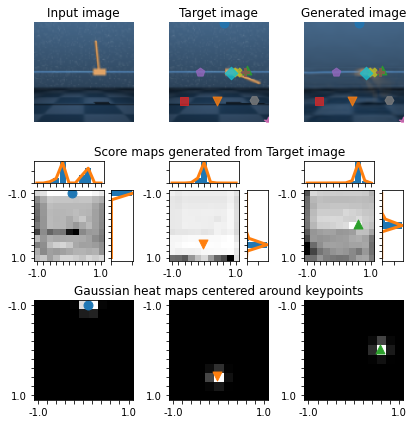

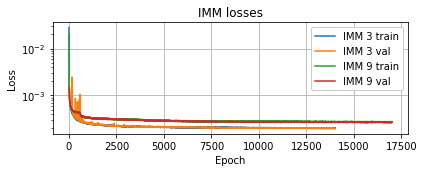

In [80]:
# Save figures?
save_fig = True

# Plot input image, target image, and generated image with keypoints, score maps, and heat maps.
markers = ["o", "v", "^", "s", "p", "P", "*", "H", "X", "D"]
symbol_sizes = 10*[80]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, axes = plt.subplots(3, 3, figsize=(6,6))
plot_image(input_im_example, axes[0,0])
axes[0,0].set_title("Input image")
plot_image_with_keypoints(target_im_example, mus_example, axes[0,1])
axes[0,1].set_title("Target image")
plot_image_with_keypoints(generated_im_example, mus_example, axes[0,2])
axes[0,2].set_title("Generated image")
plot_map_with_keypoint_and_marginals(score_maps_example[0, :, :],
                                     mus_example[0, :],
                                     probs_xs_example[0, :],
                                     probs_ys_example[0, :],
                                     axes[1,0],
                                     markers[0],
                                     symbol_sizes[0],
                                     colors[0])
_, ax_tmp, _ = plot_map_with_keypoint_and_marginals(map=score_maps_example[1, :, :],
                                     mu=mus_example[1, :],
                                     probs_x=probs_xs_example[1, :],
                                     probs_y=probs_ys_example[1, :],
                                     ax_joint=axes[1,1],
                                     marker=markers[1],
                                     symbol_size=symbol_sizes[1],
                                     color=colors[1])
ax_tmp.set_title("        Score maps generated from Target image")
plot_map_with_keypoint_and_marginals(map=score_maps_example[2, :, :],
                                     mu=mus_example[2, :],
                                     probs_x=probs_xs_example[2, :],
                                     probs_y=probs_ys_example[2, :],
                                     ax_joint=axes[1,2],
                                     marker=markers[2],
                                     symbol_size=symbol_sizes[2],
                                     color=colors[2])

plot_map_with_keypoint(map=heat_maps_example[0, :, :],
                       mu=mus_example[0, :],
                       ax=axes[2,0],
                       marker=markers[0],
                       symbol_size=symbol_sizes[0],
                       color=colors[0])
plot_map_with_keypoint(map=heat_maps_example[1, :, :],
                       mu=mus_example[1, :],
                       ax=axes[2,1],
                       marker=markers[1],
                       symbol_size=symbol_sizes[1],
                       color=colors[1])
axes[2,1].set_title("Gaussian heat maps centered around keypoints")
plot_map_with_keypoint(map=heat_maps_example[2, :, :],
                       mu=mus_example[2, :],
                       ax=axes[2,2],
                       marker=markers[2],
                       symbol_size=symbol_sizes[2],
                       color=colors[2])
plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.2)
if save_fig:
    fig.savefig("IMM3_results.pdf")


# Plot loss curve of both IMM 3 and IMM 9
fig, ax = plt.subplots(1,1,figsize=(6, 2.5))
cmap = plt.get_cmap("tab10")
plot_loss(train_losses, None, "train", 1, True, ax)
plot_loss(val_losses, None, "validation", val_freq, True, ax)
plot_loss(train_losses_9, None, "train", 1, True, ax, color=cmap(2))
plot_loss(val_losses_9, None, "validation", val_freq, True, ax, color=cmap(3))
ax.set_title("IMM losses")
ax.legend(["IMM 3 train", "IMM 3 val", "IMM 9 train", "IMM 9 val"], framealpha=1)
plt.tight_layout()
if save_fig:
    fig.savefig("IMM_losses.pdf")

#### Plots showcasing the network's sensitivity to keypoint locations
##### Definition of functions required to obtain output from a keypoint learning network where a keypoint location has been changed

In [67]:
def get_random_eps(sigma: Union[float, Tensor] = 0.1,
                   size: Union[int, Tuple[int], Tensor] = 2):
    eps = torch.randn(size) * sigma
    return eps


def get_output_from_net_with_changed_mu(net,
                                        input_image: Tensor,
                                        target_image: Tensor,
                                        channels: List[int],
                                        epsilons: List[Union[Tensor, float]]):
    assert len(epsilons) == len(channels)
    
    # Get image encoder output
    imagenet_output = net.ImageNet(input_image) 
    encoded_image = imagenet_output[1]

    # Get score maps from KeyNet functions
    features = net.KeyNet.image_encoder(target_image)[1]
    score_maps = net.KeyNet.features_to_score_maps(features)
    changed_mu, probs_x, probs_y = net.KeyNet.key_points_from_score_maps(score_maps)

    # Change mu and ensure mu coordinates are between -1 and 1
    for eps, channel in zip(epsilons, channels):
        mu_tmp = changed_mu[:, channel, :]
        mu_tmp += eps
        mu_tmp[torch.abs(mu_tmp) > 1] = torch.sign(mu_tmp[torch.abs(mu_tmp) > 1])
        changed_mu[:, channel, :] = mu_tmp

    # Get KeyNet output with changed score map
    heat_maps = net.KeyNet.heat_maps_from_key_points(changed_mu, score_maps.shape[-2:])
    keynet_output = [heat_maps, changed_mu, score_maps, probs_x, probs_y]
    heatmaps = keynet_output[0]

    # Generate target with changed score map and output all results
    generated_target = net.GenNet(encoded_image, heatmaps)
    changed_output = [generated_target, imagenet_output, keynet_output]
    
    return changed_output

##### Plot showcasing the sensitivity of each keypoint

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


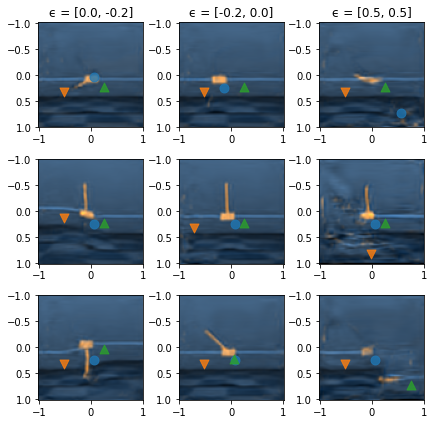

In [68]:
# Save figures?
save_fig = True

input_image = minibatch_input
target_image = minibatch_target
epsilons = [[torch.tensor([0, -0.2])], [torch.tensor([-0.2, 0])], [torch.tensor([0.5, 0.5])]]

fig, axes = plt.subplots(3, 3, figsize=(6,6))

for i in range(3):
    for j in range(3):
        epsilon = epsilons[j]
        channel = [i]
        changed_output = get_output_from_net_with_changed_mu(net=net,
                                                             input_image=input_image,
                                                             target_image=target_image,
                                                             channels=channel,
                                                             epsilons=epsilon)
        changed_minibatch_est = changed_output[0]
        changed_key_net_output = changed_output[2]

        # Extract changed results to numpy variables
        changed_generated_im_example = changed_minibatch_est[0, :, :, :].cpu().detach().numpy()
        changed_mus_example = changed_key_net_output[1][0,:,:].cpu().detach().numpy()
        
        # Plot image generated with changed keypoint
        ax = axes[i, j]
        plot_image_with_keypoints(changed_generated_im_example, changed_mus_example, ax, axis_on=True)
        if i == 0:
            ax.set_title("ϵ = [{0:.1f}, {1:.1f}]".format(epsilon[0][0], epsilon[0][1]))

plt.tight_layout()
if save_fig:
    fig.savefig("KeyNet3_keypoint_sensitivity_3x3.pdf")

##### Plot showcasing what happens if all keypoints are moved at the same time by the same amount

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


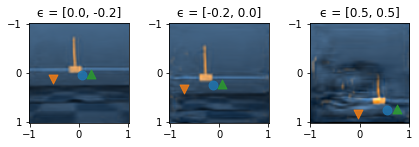

In [70]:
# Save figures?
save_fig = True

input_image = minibatch_input
target_image = minibatch_target
epsilons = [[torch.tensor([0, -0.2]), torch.tensor([0, -0.2]), torch.tensor([0, -0.2])],
            [torch.tensor([-0.2, 0]), torch.tensor([-0.2, 0]), torch.tensor([-0.2, 0])],
            [torch.tensor([0.5, 0.5]), torch.tensor([0.5, 0.5]), torch.tensor([0.5, 0.5])]]

fig, axes = plt.subplots(1, 3, figsize=(6,2))

for i in range(3):
        epsilon = epsilons[i]
        channel = [0, 1, 2]
        changed_output = get_output_from_net_with_changed_mu(net=net,
                                                             input_image=input_image,
                                                             target_image=target_image,
                                                             channels=channel,
                                                             epsilons=epsilon)
        changed_minibatch_est = changed_output[0]
        changed_key_net_output = changed_output[2]

        # Extract changed results to numpy variables
        changed_generated_im_example = changed_minibatch_est[0, :, :, :].cpu().detach().numpy()
        changed_mus_example = changed_key_net_output[1][0,:,:].cpu().detach().numpy()
        
        # Plot image generated with changed keypoints
        ax = axes[i]
        plot_image_with_keypoints(changed_generated_im_example, changed_mus_example, ax, axis_on=True)
        ax.set_title("ϵ = [{0:.1f}, {1:.1f}]".format(epsilon[0][0], epsilon[0][1]))

plt.tight_layout()
if save_fig:
    fig.savefig("KeyNet3_keypoint_sensitivity_all_moved.pdf")

## SAC/RAD
### IMM definition as used in SAC/RAD

In [74]:
OUT_DIM = {2: 39, 4: 35, 6: 31}

def tie_weights(src, trg):
    assert type(src) == type(trg)
    trg.weight = src.weight
    trg.bias = src.bias


def compute_size(hw, paddings, kernels, strides):
    assert len(paddings) == len(kernels) == len(strides)

    for i in range(len(paddings)):
        hw = int((hw + 2 * paddings[i] - kernels[i])/strides[i] + 1)

    return hw     


class PixelEncoder(nn.Module):
    """Convolutional encoder of pixels observations."""
    def __init__(self, obs_shape, feature_dim, num_layers=4, num_filters=32):
        super().__init__()

        assert len(obs_shape) == 3

        self.feature_dim = feature_dim
        self.num_layers = num_layers
        self.output_sizes = []
        self.convs = nn.ModuleList(
            [nn.Conv2d(obs_shape[0], num_filters, kernel_size=7, padding=3, stride=2)]
        )
        for i in range(num_layers - 2):
            self.convs.append(nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1, stride=2))
        self.convs.append(nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1, stride=1))
        dummy_obs = torch.randn([1] + list(obs_shape))
        self.output_sizes.append(dummy_obs.size())
        for conv_op in self.convs:
            dummy_obs = conv_op(dummy_obs)
            self.output_sizes.append(dummy_obs.size())

        self.out_dim = compute_size(obs_shape[-1], 
                                    paddings=[3] + (num_layers-2)*[1] + [1], 
                                    kernels=[7] + (num_layers-2)*[3] + [3], 
                                    strides=[2] + (num_layers-2)*[2] + [1]) 
        self.fc = nn.Linear(num_filters * self.out_dim * self.out_dim, self.feature_dim)
        self.ln = nn.LayerNorm(self.feature_dim)

        self.outputs = dict()

    def reparameterize(self, mu, logstd):
        std = torch.exp(logstd)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward_conv(self, obs):
        # obs = obs / 255.
        self.outputs['obs'] = obs

        conv = torch.relu(self.convs[0](obs))
        self.outputs['conv1'] = conv

        for i in range(1, self.num_layers):
            conv = torch.relu(self.convs[i](conv))
            self.outputs['conv%s' % (i + 1)] = conv

        h = conv.view(conv.size(0), -1)
        return h, conv

    def forward(self, obs, detach=False):
        h, _ = self.forward_conv(obs)

        if detach:
            h = h.detach()

        h_fc = self.fc(h)
        self.outputs['fc'] = h_fc

        h_norm = self.ln(h_fc)
        self.outputs['ln'] = h_norm

        out = torch.tanh(h_norm)
        self.outputs['tanh'] = out

        return out

    def copy_conv_weights_from(self, source):
        """Tie convolutional layers"""
        # only tie conv layers
        for i in range(self.num_layers):
            tie_weights(src=source.convs[i], trg=self.convs[i])

    def log(self, L, step, log_freq):
        if step % log_freq != 0:
            return

        for k, v in self.outputs.items():
            L.log_histogram('train_encoder/%s_hist' % k, v, step)
            if len(v.shape) > 2:
                L.log_image('train_encoder/%s_img' % k, v[0], step)

        for i in range(self.num_layers):
            L.log_param('train_encoder/conv%s' % (i + 1), self.convs[i], step)
        L.log_param('train_encoder/fc', self.fc, step)
        L.log_param('train_encoder/ln', self.ln, step)


class IdentityEncoder(nn.Module):
    def __init__(self, obs_shape, feature_dim, num_layers, num_filters):
        super().__init__()

        assert len(obs_shape) == 1
        self.feature_dim = obs_shape[0]

    def forward(self, obs, detach=False):
        return obs

    def copy_conv_weights_from(self, source):
        pass

    def log(self, L, step, log_freq):
        pass


_AVAILABLE_ENCODERS = {'pixel': PixelEncoder, 'identity': IdentityEncoder}


def make_encoder(
    encoder_type, obs_shape, feature_dim, num_layers, num_filters
):
    assert encoder_type in _AVAILABLE_ENCODERS
    return _AVAILABLE_ENCODERS[encoder_type](
        obs_shape, feature_dim, num_layers, num_filters
    )


class KeyNet(nn.Module):
    """Convolutional encoder of pixels observations."""
    def __init__(self, obs_shape, encoder_feature_dim, num_layers=4, num_filters=32, num_keypoints=10, sigma=0.1):
        super().__init__()

        assert len(obs_shape) == 3

        self.num_layers = num_layers

        # keynet's image encoder. Similar to AE's image encoder
        self.image_encoder = make_encoder('pixel', obs_shape, encoder_feature_dim, num_layers, num_filters)
        
        self.features_to_score_maps = nn.Conv2d(in_channels = num_filters, 
                                                out_channels = num_keypoints, 
                                                kernel_size = 1,
                                                stride = 1,
                                                padding = 0,
                                                dilation = 1,
                                                groups=1,
                                                bias = True)
        self.num_keypoints = num_keypoints
        self.sigma = sigma

        self.outputs = dict()

    def key_points_from_score_maps(self, score_maps: Tensor) -> Tuple[Tensor, Tensor, Tensor]:
        x_coor_vector = torch.linspace(-1, 1, score_maps.shape[3], device=score_maps.device)
        y_coor_vector = torch.linspace(-1, 1, score_maps.shape[2], device=score_maps.device)
        probs_x = F.softmax(score_maps.mean(axis=2), dim=2)
        probs_y = F.softmax(score_maps.mean(axis=3), dim=2)
        mu_x = torch.sum(probs_x * x_coor_vector, dim=2)
        mu_y = torch.sum(probs_y * y_coor_vector, dim=2)
        mu = torch.cat((mu_x.unsqueeze(dim=2), mu_y.unsqueeze(dim=2)), dim=2)
        return mu, probs_x, probs_y

    def heat_maps_from_score_maps(self, score_maps: Tensor) -> Tuple[Tensor, Tensor, Tensor, Tensor]:
        mu, probs_x, probs_y = self.key_points_from_score_maps(score_maps)

        # The remaining part of this function is very similar to Nicklas' implementation
        mu_x, mu_y = mu[:,:,0:1].unsqueeze(dim=3), mu[:,:,1:2].unsqueeze(dim=3)

        x_coor_vector = torch.linspace(-1, 1, score_maps.shape[3], device=score_maps.device)
        y_coor_vector = torch.linspace(-1, 1, score_maps.shape[2], device=score_maps.device)
        x = x_coor_vector.reshape((1, 1, 1, len(x_coor_vector)))
        y = y_coor_vector.reshape((1, 1, len(y_coor_vector), 1))

        g_x = (x - mu_x) ** 2
        g_y = (y - mu_y) ** 2
        heat_maps = torch.exp((g_x + g_y) * (-1 / (2 * self.sigma ** 2)))

        return heat_maps, mu, probs_x, probs_y


    def forward(self, input_image: Tensor, detach=False) -> List[Tensor]:
        _, features = self.image_encoder.forward_conv(input_image)
        if detach:
            features.detach()
        score_maps = self.features_to_score_maps(features)
        heat_maps, mu, probs_x, probs_y = self.heat_maps_from_score_maps(score_maps)

        return [heat_maps, mu, score_maps, probs_x, probs_y]


class GenNet(nn.Module):
    
    """This is used as a decoder for an image to be used in KeyPoint-learning

    Documenation for each class method can be found in the given method

    Note:
        The default parameters is set as in IMM.py by Nicklas

    Class methods:
        generator_layer: Returns a sequential list of n cnn layers

    """
    
    def __init__(self,
                 n_channels_in_ImEncoder: int,
                 n_channels_in_Heatmaps: int, 
                 n_channels_out: int = 3,
                 resolution_in: int = 11,
                 resolution_out: int = 84, 
                 device: str = 'cpu'):
        super(GenNet, self).__init__()

        self.filters_in = n_channels_in_ImEncoder + n_channels_in_Heatmaps
        self.filters_out = n_channels_in_ImEncoder
        self.n_channels_out = n_channels_out
        self.resolution_in = resolution_in
        self.resolution_out = resolution_out
        self.device = device

        self.generator = self.generator_layer()
        
    def generator_layer(self) -> nn.Sequential:
        
        layers = [] #The sequential list
        image_size = self.resolution_in
        final_image_size = self.resolution_out
        filters_in = self.filters_in
        filters_out = self.filters_out
        n_channels_out = self.n_channels_out

        # First layer
        layers.append(nn.Conv2d(filters_in, filters_out, kernel_size=3, stride=1, padding=1, bias=True))
        layers.append(nn.BatchNorm2d(filters_out))
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(filters_out, filters_out, kernel_size=3, stride=1, padding=1, bias=True))
        layers.append(nn.BatchNorm2d(filters_out))
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False))
        image_size *= 2
        filters_in = filters_out
        filters_out = int(filters_out/2)
        # Following layers
        while image_size <= final_image_size:
            layers.append(nn.Conv2d(filters_in, filters_out, kernel_size=3, stride=1, padding=1, bias=True))
            layers.append(nn.BatchNorm2d(filters_out))
            layers.append(nn.ReLU(inplace=True))
            if image_size == final_image_size:
                layers.append(nn.Conv2d(filters_out, n_channels_out, kernel_size=3, stride=1, padding=1, bias=True))
                break
            else:
                layers.append(nn.Conv2d(filters_out, filters_out, kernel_size=3, stride=1, padding=1, bias=True))
                layers.append(nn.BatchNorm2d(filters_out))
                layers.append(nn.ReLU(inplace=True))
                layers.append(nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False))
                image_size *= 2

            if filters_out >= 8:
                filters_in = filters_out
                filters_out = int(filters_out / 2)
            else:
                filters_in = filters_out
        if image_size > final_image_size:
            layers.append(nn.Conv2d(filters_in, n_channels_out, kernel_size=3, stride=1, padding=1, bias=True))
            layers.append(nn.UpsamplingBilinear2d(size=final_image_size))
        return nn.Sequential(*layers)
    
    def forward(self,
                encoded_image: Tensor,
                heatmaps: Tensor) -> Tensor:
        return self.generator(torch.cat((encoded_image, heatmaps), dim=1))


class IMM(nn.Module):
    def __init__(self, obs_shape, encoder_feature_dim, num_layers, num_filters, num_keypoints, sigma):
        super(IMM, self).__init__()
        
        self.ImageEncoder = make_encoder('pixel', obs_shape, encoder_feature_dim, num_layers, num_filters)
        self.KeyNet = make_keynet(obs_shape, encoder_feature_dim, num_layers, num_filters, num_keypoints, sigma)
        self.GenNet = make_gennet(obs_shape, num_filters, num_keypoints, encoded_image_size=self.KeyNet.image_encoder.out_dim)
        # self.output = None

    def forward(self, input_image: Tensor,
            target_image: Tensor) -> Tuple[Tensor, List[Tensor], List[Tensor]]:
        _, imagenet_output = self.ImageEncoder.forward_conv(input_image) 
        encoded_image = imagenet_output

        keynet_output = self.KeyNet(target_image)
        heatmaps = keynet_output[0]

        generated_target = self.GenNet(encoded_image, heatmaps)
        # self.output = (generated_target, imagenet_output, keynet_output)
        return generated_target, imagenet_output, keynet_output
        

def make_keynet(obs_shape=[9, 84, 84], encoder_feature_dim=50, num_layers=4, num_filters=32, num_keypoints=10, sigma=0.1):
    return KeyNet(obs_shape, encoder_feature_dim, num_layers, num_filters, num_keypoints, sigma)


def make_gennet(obs_shape=[9, 84, 84], num_filters=32, num_keypoints=10, encoded_image_size=11):
    return GenNet(n_channels_in_ImEncoder=num_filters, 
                  n_channels_in_Heatmaps=num_keypoints, 
                  n_channels_out = obs_shape[0],
                  resolution_in=encoded_image_size,
                  resolution_out=obs_shape[-1])

                             
def make_imm(obs_shape=[9, 84, 84], encoder_feature_dim=50, num_layers=4, num_filters=32, num_keypoints=10, sigma=0.1):
    return IMM(obs_shape, encoder_feature_dim, num_layers, num_filters, num_keypoints, sigma)

### Code for loading log from training

In [75]:
def load_log(log_path: str, log_keys: List[str]) -> tuple:
    assert os.path.isfile(log_path), "File path: {}, is invalid.".format(log_path)

    with open(log_path, "r") as log_file:
        log_lines = log_file.readlines()

    log_dicts = [json.loads(line) for line in log_lines]
    train_log_values = list(zip(*[[log_dict[key] for key in log_keys] for log_dict in log_dicts if not [None for key in log_keys if key not in log_dict.keys()]]))

    return train_log_values

### Visualisation of SAC/RAD results for the various experiments described in the report
#### Visualisation of keypoint learning results for IMM networks trained during RL

Loading imm_90000_modified.pt
Loading imm_250000_only_keypoints.pt


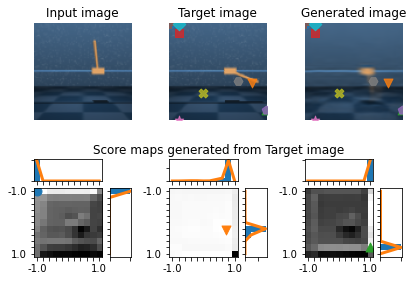

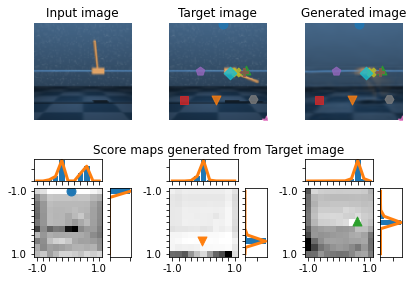

In [76]:
# Save figures?
save_fig = False

# Load example from original data
device = "cpu"
input_example = data_cartpole[0][2550:2551].to(device)
target_example = data_cartpole[1][7520:7521].to(device)

# Load IMM checkpoints from RAD+IMM and SAC+IMM training
checkpoint_folders = [os.path.join(base_folder_path, "Checkpoints"),
                      os.path.join(base_folder_path, "Checkpoints")]
checkpoint_names = ["imm_90000_modified.pt", "imm_250000_only_keypoints.pt"]
save_names = ["KeyNet_results_modified.pdf", "KeyNet_results_only_keypoints.pdf"]

for i in range(len(checkpoint_folders)):
    checkpoint_folder = checkpoint_folders[i]
    checkpoint_name = checkpoint_names[i]
    checkpoint = load_checkpoint(checkpoint_name=checkpoint_name,
                                 checkpoint_folder=checkpoint_folder,
                                 map_location=device)
    imm = make_imm()
    imm.load_state_dict(checkpoint)
    imm.eval()

    # Get output from IMM
    output = imm(input_example, target_example)
    generated_example = output[0]
    key_net_output = output[2]

    # Reformat variables
    input_im_example = input_example[0, :3, :, :].cpu().detach().numpy()
    target_im_example = target_example[0, :3, :, :].cpu().detach().numpy()
    generated_im_example = generated_example[0, :3, :, :].cpu().detach().numpy()
    heat_maps_example = key_net_output[0][0,:,:,:].cpu().detach().numpy()
    mus_example = key_net_output[1][0,:,:].cpu().detach().numpy()
    score_maps_example = key_net_output[2][0,:,:,:].cpu().detach().numpy()
    probs_xs_example = key_net_output[3][0,:,:].cpu().detach().numpy()
    probs_ys_example = key_net_output[4][0,:,:].cpu().detach().numpy()

    # Plot IMM checkpoint results
    # Plot input image, target image, and generated image with keypoints.
    markers = ["o", "v", "^", "s", "p", "P", "*", "H", "X", "D"]
    symbol_sizes = 10*[80]
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    fig, axes = plt.subplots(2, 3, figsize=(6,4))
    plot_image(input_im_example, axes[0,0])
    axes[0,0].set_title("Input image")
    plot_image_with_keypoints(target_im_example, mus_example, axes[0,1])
    axes[0,1].set_title("Target image")
    plot_image_with_keypoints(generated_im_example, mus_example, axes[0,2])
    axes[0,2].set_title("Generated image")
    plot_map_with_keypoint_and_marginals(score_maps_example[0, :, :],
                                        mus_example[0, :],
                                        probs_xs_example[0, :],
                                        probs_ys_example[0, :],
                                        axes[1,0],
                                        markers[0],
                                        symbol_sizes[0],
                                        colors[0])
    _, ax_tmp, _ = plot_map_with_keypoint_and_marginals(map=score_maps_example[1, :, :],
                                        mu=mus_example[1, :],
                                        probs_x=probs_xs_example[1, :],
                                        probs_y=probs_ys_example[1, :],
                                        ax_joint=axes[1,1],
                                        marker=markers[1],
                                        symbol_size=symbol_sizes[1],
                                        color=colors[1])
    ax_tmp.set_title("        Score maps generated from Target image")
    plot_map_with_keypoint_and_marginals(map=score_maps_example[2, :, :],
                                        mu=mus_example[2, :],
                                        probs_x=probs_xs_example[2, :],
                                        probs_y=probs_ys_example[2, :],
                                        ax_joint=axes[1,2],
                                        marker=markers[2],
                                        symbol_size=symbol_sizes[2],
                                        color=colors[2])

    """plot_map_with_keypoint(map=heat_maps_example[0, :, :],
                        mu=mus_example[0, :],
                        ax=axes[2,0],
                        marker=markers[0],
                        symbol_size=symbol_sizes[0],
                        color=colors[0])
    plot_map_with_keypoint(map=heat_maps_example[1, :, :],
                        mu=mus_example[1, :],
                        ax=axes[2,1],
                        marker=markers[1],
                        symbol_size=symbol_sizes[1],
                        color=colors[1])
    axes[2,1].set_title("Gaussian heat maps centered around keypoints")
    plot_map_with_keypoint(map=heat_maps_example[2, :, :],
                        mu=mus_example[2, :],
                        ax=axes[2,2],
                        marker=markers[2],
                        symbol_size=symbol_sizes[2],
                        color=colors[2])"""
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.4, wspace=0.2)
    if save_fig:
        fig.savefig(save_names[i])

#### Plots of SAC losses and rewards for the experiments described in the report
#####  Plots from experiments which utilise coupled models -- i.e. Actor and Critic losses from SAC/RAD are used to update KeyNet and Encoder
In the results below, IMM, if used, is trained from scratch along with SAC/RAD in a "coupled" manner and IMM 9 is always used.

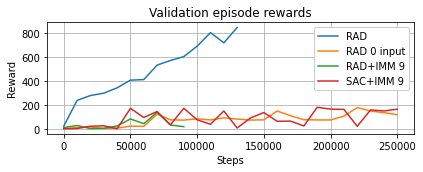

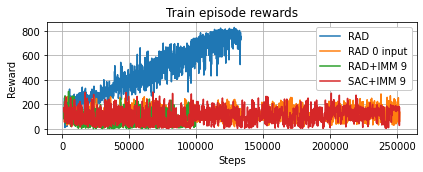

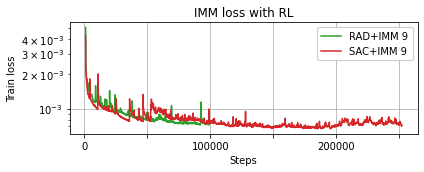

In [83]:
# Save figures?
save_fig = True

# Define train log paths
log_folder = os.path.join(base_folder_path, "Logs")
train_log_names = ["RAD_train.log", "zero_input_train.log", "RAD_IMM9_train.log", "SAC_IMM9_train.log"]
eval_log_names = ["RAD_eval.log", "zero_input_eval.log", "RAD_IMM9_eval.log", "SAC_IMM9_eval.log"]
train_log_keys = [["critic_loss", "actor_loss", "episode_reward", "step"],
                  ["critic_loss", "actor_loss", "episode_reward", "step"],
                  ["critic_loss", "actor_loss", "episode_reward", "step", "imm_imm_loss"],
                  ["critic_loss", "actor_loss", "episode_reward", "step", "imm_imm_loss"]]
eval_log_keys = ["episode_reward", "step"]
labels = ["RAD", "RAD 0 input", "RAD+IMM 9", "SAC+IMM 9"]
linestyles = ["-", "-", "-", "-"]

# Set colormap scheme
cmap = plt.get_cmap("tab10")

# Plot rewards and losses in different figures
fig_val_reward, axes_val_reward = plt.subplots(1, 1, figsize=(6, 2.5))
fig_train_reward, axes_train_reward = plt.subplots(1, 1, figsize=(6, 2.5))
# fig_loss, axes_loss = plt.subplots(1, 2, sharey=True, figsize=(6, 2.5))
fig_loss, ax_loss = plt.subplots(1, 1, figsize=(6, 2.5))

for i in range(len(train_log_names)):
    train_log_path = os.path.join(log_folder, train_log_names[i])
    eval_log_path = os.path.join(log_folder, eval_log_names[i])

    # Load train log
    train_log_values = load_log(train_log_path, train_log_keys[i])

    if len(train_log_values) == 4:
        critic_loss, actor_loss, train_episode_reward, train_steps = train_log_values
        imm_loss = None
    else:
        critic_loss, actor_loss, train_episode_reward, train_steps, imm_loss = train_log_values

    # Load eval log
    eval_log_values = load_log(eval_log_path, eval_log_keys)
    eval_episode_reward, eval_steps = eval_log_values

    label = labels[i]
    linestyle = linestyles[i]
    color = cmap(i)

    # Plot eval episode reward
    ax = axes_val_reward
    ax.plot(eval_steps, eval_episode_reward, color=color, linestyle=linestyle, label=label)
    ax.set_axisbelow(True)
    ax.grid(True)
    ax.set_xlabel("Steps")
    ax.set_ylabel("Reward")
    ax.set_title("Validation episode rewards")
    ax.legend(framealpha=1, loc='upper right')

    # Plot train episode reward
    ax = axes_train_reward
    ax.plot(train_steps, train_episode_reward, color=color, linestyle=linestyle, label=label)
    ax.set_axisbelow(True)
    ax.grid(True)
    ax.set_xlabel("Steps")
    ax.set_ylabel("Reward")
    ax.set_title("Train episode rewards")
    ax.legend(framealpha=1, loc='upper right')

    # Plot imm loss if available
    if "imm_imm_loss" in train_log_keys[i]:
        ax = ax_loss
        ax.plot(train_steps, imm_loss, color=color, linestyle=linestyle, label=label)
        ax.set_axisbelow(True)
        ax.grid(True)
        ax.set_yscale('log')
        ax.set_xlabel("Steps")
        ax.set_ylabel("Train loss")
        ax.set_title("IMM loss with RL")
        ax.legend(framealpha=1)

# Plot loss curve
# ax = axes_loss[1]
# plot_loss(train_losses, None, "train", 1, True, ax, "red")
# plot_loss(val_losses, None, "validation", val_freq, True, ax, "blue")
# ax.set_title("IMM loss without RL")
# ax.legend(framealpha=1)

ax = ax_loss
[l.set_visible(False) for (i, l) in enumerate(ax.xaxis.get_ticklabels()) if i % 2 == 0]

# Save figures
fig_loss.tight_layout()
fig_train_reward.tight_layout()
# if save_fig:
#     fig_loss.savefig("SAC_and_KeyNet_loss.pdf")

fig_val_reward.tight_layout()
if save_fig:
    fig_val_reward.savefig("SAC_reward.pdf")


#####  Plots from experiments which utilise parallel models -- i.e. Actor and Critic losses from SAC/RAD are not used to update KeyNet and Encoder
In the results below, IMM, if used, has been pretrained or is trained from scratch along with SAC/RAD in a parallel manner and IMM 9 is always used. The pretrained IMM models continued training alongside SAC/RAD.

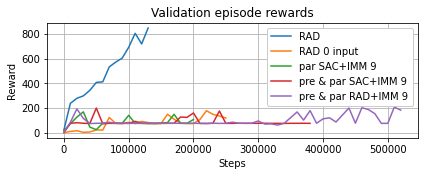

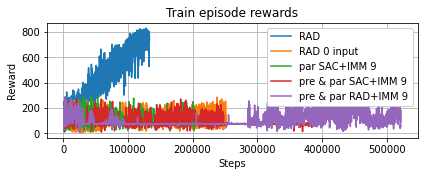

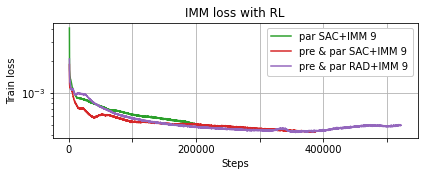

In [86]:
# Save figures?
save_fig = True

# Define train log paths
log_folder = os.path.join(base_folder_path, "Logs")
train_log_names = ["RAD_train.log", "zero_input_train.log", "par_SAC_IMM9_train.log", "pre_par_SAC_IMM9_train.log", "pre_par_RAD_IMM9_train.log"]
eval_log_names = ["RAD_eval.log", "zero_input_eval.log", "par_SAC_IMM9_eval.log", "pre_par_SAC_IMM9_eval.log", "pre_par_RAD_IMM9_eval.log"]
train_log_keys = [["critic_loss", "actor_loss", "episode_reward", "step"],
                  ["critic_loss", "actor_loss", "episode_reward", "step"],
                  ["critic_loss", "actor_loss", "episode_reward", "step", "imm_imm_loss"],
                  ["critic_loss", "actor_loss", "episode_reward", "step", "imm_imm_loss"],
                  ["critic_loss", "actor_loss", "episode_reward", "step", "imm_imm_loss"]]
eval_log_keys = ["episode_reward", "step"]
labels = ["RAD", "RAD 0 input", "par SAC+IMM 9", "pre & par SAC+IMM 9", "pre & par RAD+IMM 9"]
linestyles = ["-", "-", "-", "-", "-"]

# Set colormap scheme
cmap = plt.get_cmap("tab10")

# Plot rewards and losses in different figures
fig_val_reward, axes_val_reward = plt.subplots(1, 1, figsize=(6, 2.55))
fig_train_reward, axes_train_reward = plt.subplots(1, 1, figsize=(6, 2.55))
# fig_loss, axes_loss = plt.subplots(1, 2, sharey=True, figsize=(6, 2.5))
fig_loss, ax_loss = plt.subplots(1, 1, figsize=(6, 2.55))

for i in range(len(train_log_names)):
    train_log_path = os.path.join(log_folder, train_log_names[i])
    eval_log_path = os.path.join(log_folder, eval_log_names[i])

    # Load train log
    train_log_values = load_log(train_log_path, train_log_keys[i])

    if len(train_log_values) == 4:
        critic_loss, actor_loss, train_episode_reward, train_steps = train_log_values
        imm_loss = None
    else:
        critic_loss, actor_loss, train_episode_reward, train_steps, imm_loss = train_log_values

    # Load eval log
    eval_log_values = load_log(eval_log_path, eval_log_keys)
    eval_episode_reward, eval_steps = eval_log_values

    label = labels[i]
    linestyle = linestyles[i]
    color = cmap(i)

    # Plot eval episode reward
    ax = axes_val_reward
    ax.plot(eval_steps, eval_episode_reward, color=color, linestyle=linestyle, label=label)
    ax.set_axisbelow(True)
    ax.grid(True)
    ax.set_xlabel("Steps")
    ax.set_ylabel("Reward")
    ax.set_title("Validation episode rewards")
    ax.legend(framealpha=1, loc='upper right')

    # Plot train episode reward
    ax = axes_train_reward
    ax.plot(train_steps, train_episode_reward, color=color, linestyle=linestyle, label=label)
    ax.set_axisbelow(True)
    ax.grid(True)
    ax.set_xlabel("Steps")
    ax.set_ylabel("Reward")
    ax.set_title("Train episode rewards")
    ax.legend(framealpha=1, loc='upper right')

    # Plot imm loss if available
    if "imm_imm_loss" in train_log_keys[i]:
        ax = ax_loss
        ax.plot(train_steps, imm_loss, color=color, linestyle=linestyle, label=label)
        ax.set_axisbelow(True)
        ax.grid(True)
        ax.set_yscale('log')
        ax.set_xlabel("Steps")
        ax.set_ylabel("Train loss")
        ax.set_title("IMM loss with RL")
        ax.legend(framealpha=1)

# Plot loss curve
# ax = axes_loss[1]
# plot_loss(train_losses, None, "train", 1, True, ax, "red")
# plot_loss(val_losses, None, "validation", val_freq, True, ax, "blue")
# ax.set_title("IMM loss without RL")
# ax.legend(framealpha=1)

ax = ax_loss
[l.set_visible(False) for (i, l) in enumerate(ax.xaxis.get_ticklabels()) if i % 2 == 0]

# Save figures
fig_loss.tight_layout()
fig_train_reward.tight_layout()
# if save_fig:
#     fig_loss.savefig("SAC_and_KeyNet_loss.pdf")

fig_val_reward.tight_layout()
if save_fig:
    fig_val_reward.savefig("SAC_reward_parallel.pdf")